In [1]:
# imports
import librosa, os
from scipy.linalg import svd, toeplitz
from scipy.stats import zscore
import numpy as np
from scipy.stats import entropy
from statsmodels.tsa.stattools import acf

from tqdm.notebook import tqdm
from random import sample
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sklearn import svm, neighbors, model_selection
from statistics import mean
from sklearn.metrics import classification_report

from pyha_analyzer import PyhaTrainer, PyhaTrainingArguments, extractors


2025-07-25 09:41:18.332612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-25 09:41:18.352762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-25 09:41:18.352795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-25 09:41:18.366110: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-25 09:41:19.215335: W tensorflow/compiler/tf

In [2]:
lag = 512

# juan colonna entropy

def Entropy(p1):
    p1 = p1/np.sum(p1)
    return entropy(p1)/np.log(len(p1))
# EGCI calculation from https://github.com/juancolonna/EGCI/blob/master/Example_of_EGCI_calculation.ipynb

def JSD(p):
    n = len(p)
    q = np.ones(n)/n # Uniform reference
    p = np.asarray(p)
    q = np.asarray(q)
    p = p/p.sum() # normalize
    m = (p + q) / 2
    jensen0 = -2*((((n+1)/n)*np.log(n+1)-2*np.log(2*n) + np.log(n))**(-1))
    return jensen0*(entropy(p, m) + entropy(q, m)) / 2

def EGCI(x):
    x = zscore(x)
    
    # Algorithm steps 
    rxx = acf(x, nlags=lag, adjusted=True, fft=True) #https://github.com/blue-yonder/tsfresh/issues/902
    Sxx = toeplitz(rxx)
    U, s, Vt = np.linalg.svd(Sxx) #svd(Sxx)
    
    print(JSD(s))
    
    return Entropy(s), Entropy(s)*JSD(s) 

def process_data(data):
    path = data["filepath"]
    
    if (".WAV" not in path) and (".wav" not in path):
        print("directory found")
        return None
    
    i = 0
    audio, sr = librosa.load(path, sr=data['sample_rate'], duration=5, offset=i)

    
    if librosa.get_duration(y = audio, sr = sr) == 0:
        return None
    
    h, c = EGCI(audio)

    
    
    output_data = {
            "path": path,
            "offset_s": 0,
            "sr": sr,
            "gt": data['labels'],
            "site": data['site_name'],
            "entropy": h,
            "complexity": c
        }
    return output_data

In [3]:
# getting all the wavs

audio_path = "/home/a.jajodia.229/acoustic/local_data/coral"

coralreef_extractor = extractors.MultiCoralReef()
coral_ads = coralreef_extractor("/home/a.jajodia.229/acoustic/local_data/coral", sampling = True)

Site_A
Site_B
Site_C
A_ND
A_D
Australia
French_Polynesia
Indonesia
count: 44558


Casting to class labels:   0%|          | 0/44558 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44558 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44558 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44558 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44558 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44558 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44558 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44558 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44558 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/18 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/42 [00:00<?, ? examples/s]

In [4]:
def process_data(data):    
    
    data = coral_ads['train'][0]

    path = data['filepath']

    audio, sr = librosa.load(path, sr=data['sample_rate'], duration=5)



    h, c = EGCI(audio)
    
    



In [5]:
df = coral_ads['train'][0:100]

In [6]:
df = pd.DataFrame.from_records(df)
df['site_name'] = df.apply(lambda row: coral_ads['train'].features['site'].names[row['site']], axis = 1)

In [7]:
def process_data_multiprocess(paths, process_data_func=process_data,  processes=8, sample=1000):
    # sample = paths.sample(sample)
    sample = paths
    
    samples = list(sample.T.to_dict().values())
    
    with Pool(processes) as p:
        data = list(tqdm(p.imap(process_data_func, samples)))
    return data

In [8]:
df

,audio,audio_in,dataset,filepath,labels,sample_rate,site,site_name
0,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Paola,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 1, 0]",48000,1,A_ND
1,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Williams_et_al_2024,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 0, 1]",48000,4,Indonesia
2,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Williams_et_al_2024,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 0, 1]",48000,2,Australia
3,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Williams_et_al_2024,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 0, 1]",48000,4,Indonesia
4,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Williams_et_al_2024,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 0, 1]",48000,2,Australia
...,...,...,...,...,...,...,...,...
95,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Lin_et_al_2021,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 1, 0]",44100,7,Site_C
96,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Lin_et_al_2021,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 1, 0]",44100,6,Site_B
97,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Williams_et_al_2024,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 0, 1]",48000,3,French_Polynesia
98,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Paola,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 1, 0]",48000,0,A_D


In [9]:
processed_data_no_none = [process_data(row) for index, row in tqdm(df.iterrows())]

0it [00:00, ?it/s]

/home/a.jajodia.229/acoustic/acoustic_knowledge_discovery/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:472: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
/home/a.jajodia.229/acoustic/acoustic_knowledge_discovery/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
df

,audio,audio_in,dataset,filepath,labels,sample_rate,site,site_name
0,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Paola,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 1, 0]",48000,1,A_ND
1,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Williams_et_al_2024,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 0, 1]",48000,2,Australia
2,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Paola,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 1, 0]",48000,0,A_D
3,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Paola,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 1, 0]",48000,0,A_D
4,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Lin_et_al_2021,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 1, 0]",44100,7,Site_C
...,...,...,...,...,...,...,...,...
95,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Lin_et_al_2021,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 1, 0]",44100,7,Site_C
96,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Williams_et_al_2024,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 0, 1]",48000,3,French_Polynesia
97,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Williams_et_al_2024,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 0, 1]",48000,3,French_Polynesia
98,<datasets.features._torchcodec.AudioDecoder ob...,{'array': '/home/a.jajodia.229/acoustic/local_...,Paola,/home/a.jajodia.229/acoustic/local_data/coral/...,"[0, 1, 0]",48000,0,A_D


In [ ]:
df = pd.DataFrame.from_records(processed_data_no_none)

df.to_csv("coral_egci.csv")

In [ ]:
df

,path,offset_s,sr,gt,site,entropy,complexity
0,/home/a.jajodia.229/acoustic/local_data/coral/...,0,48000,"[0, 1, 0]",A_ND,0.940460,0.099030
1,/home/a.jajodia.229/acoustic/local_data/coral/...,0,48000,"[0, 0, 1]",Australia,0.945785,0.125576
2,/home/a.jajodia.229/acoustic/local_data/coral/...,0,48000,"[0, 1, 0]",A_D,0.919391,0.151052
3,/home/a.jajodia.229/acoustic/local_data/coral/...,0,48000,"[0, 1, 0]",A_D,0.866285,0.207986
4,/home/a.jajodia.229/acoustic/local_data/coral/...,0,44100,"[0, 1, 0]",Site_C,0.448411,0.364640
...,...,...,...,...,...,...,...
95,/home/a.jajodia.229/acoustic/local_data/coral/...,0,44100,"[0, 1, 0]",Site_C,0.768324,0.292713
96,/home/a.jajodia.229/acoustic/local_data/coral/...,0,48000,"[0, 0, 1]",French_Polynesia,0.928456,0.157787
97,/home/a.jajodia.229/acoustic/local_data/coral/...,0,48000,"[0, 0, 1]",French_Polynesia,0.946016,0.125978
98,/home/a.jajodia.229/acoustic/local_data/coral/...,0,48000,"[0, 1, 0]",A_D,0.922942,0.144477


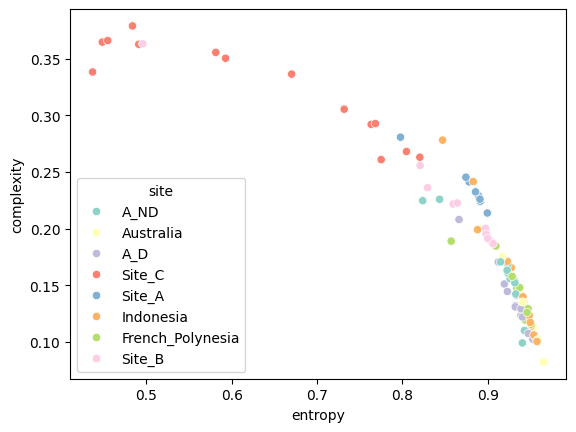

In [ ]:
with sns.color_palette("Set3"):
    sns.scatterplot(df, x = 'entropy', y = 'complexity', hue = 'site', palette='Set3')

In [ ]:

fig = plt.figure(figsize=(11,9))
plt.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
plt.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
# for i in range(len(H)):
plt.scatter(df_degraded["entropy"], df_degraded["complexity"], marker='.', s=5, cmap='viridis', label="Degraded")
plt.scatter(df_non_degraded["entropy"], df_non_degraded["complexity"], marker='.', s=5, cmap='viridis', label="Non_degraded")

plt.xlim([0, 1])
plt.ylim([0, np.max(cotas['Complexity'])+0.01])
plt.ylabel('Complexity [Cf]')
plt.xlabel('Entropy [Hf]')
lgnd = plt.legend(loc = 'best')
# set sizes of points in legend to be the same
for handle in lgnd.legend_handles:
    try:
        handle.set_sizes([200.0])
    except:
        continue
fig.axes[0].set_title(f"Reef Degradation By EGCI")

NameError: name 'cotas' is not defined

<Figure size 1100x900 with 0 Axes>

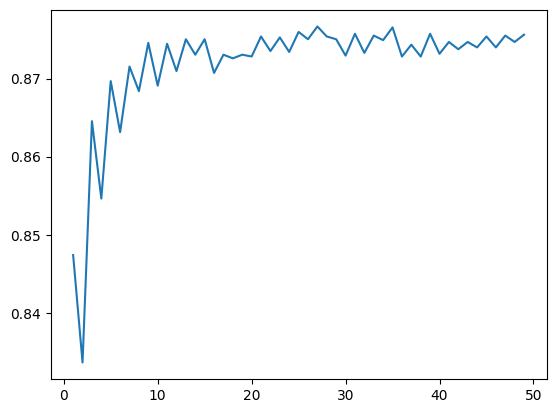

In [ ]:
accs = []
params = [i for i in range(1,50, 1)]


for i in range(1, 50, 1):
    clf = neighbors.KNeighborsClassifier(n_neighbors = i)


    X = df[['entropy', 'complexity']]
    y = (df['gt'] == "Degraded reef")

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.33, random_state=42)
    clf.fit(X_train, y_train)

    actual = mean(clf.predict(X_test) == y_test)
    
    accs.append(actual)

plt.plot(params, accs)

In [ ]:
actual = sum(clf.predict(X_test) == y_test)/len(y_test)

actual

0.8756120307764047

In [ ]:
permutations = []
# permutation testing
for i in range(10**4):
    permutations.append(mean(np.random.choice(y_test, len(y_test)) == y_test))

num_sig = 0
for perm in permutations:
    if perm > actual:
        num_sig += 1

p = num_sig / 10**4

In [ ]:
report = classification_report(y_test, clf.predict(X_test)) 

In [ ]:
print(report)

              precision    recall  f1-score   support

       False       0.93      0.85      0.89      5012
        True       0.81      0.91      0.86      3566

    accuracy                           0.88      8578
   macro avg       0.87      0.88      0.87      8578
weighted avg       0.88      0.88      0.88      8578

